# AOS_corner_sensors_simulate

A notebook to use part of AOS_letter_simulate.ipynb,  to make either one-star-per-sensor, grid of stars,  or grid with varying magnitude, all for testing purposes. 

In [1]:
from lsst.ts.phosim.SkySim import SkySim
import numpy as np 
from astropy.table import Table
from astropy.table import  hstack
from astropy.table import  vstack
import matplotlib.pyplot as plt

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


(0.0, 4000.0)

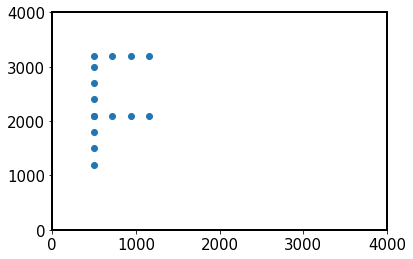

In [6]:
def pixel_letter_F(xmin=500,ymin=200,width=800,height=1200,xspacing=220,yspacing=200):
    ''' Make an array of x,y pixels that looks like letter F, eg. for 
    phoSim simulation of non-uniform stellar patterns.

    '''
    xmax = xmin+width
    ymax = ymin+height
    # initialize array storing coords for all pixels 
    xPx = np.zeros(0)
    yPx = np.zeros(0)

    # middle horizontal line
    x_mid = np.arange(xmin,xmax,xspacing)
    y_mid = np.ones_like(x_mid) * ((ymin+ymax)/2.)
    xPx = np.append(xPx, x_mid)
    yPx = np.append(yPx, y_mid)
    
    # top horizontal line
    x_top = x_mid.copy()
    y_top = np.ones_like(x_top)*ymax
    xPx = np.append(xPx, x_top)
    yPx = np.append(yPx, y_top)

    # vertical line
    y_vert = np.arange(ymin+200,ymax-100,yspacing)
    x_vert = np.ones_like(y_vert)*xmin
    xPx = np.append(xPx, x_vert)
    yPx = np.append(yPx, y_vert)

    return xPx, yPx


%matplotlib inline
x,y  = pixel_letter_F(xmin=500,ymin=1000,yspacing=300, height=2200 )
plt.scatter(x,y)
plt.xlim(0,4000)
plt.ylim(0,4000)

(0.0, 4000.0)

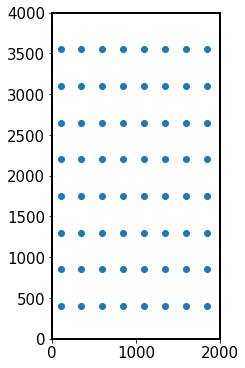

In [21]:
def star_array(xmin=100, ymin=100, Nx=8, Ny=8, dx=250, dy=250):
    ''' Make a regular Nx by Ny array of stars - a grid. 
    Can be used eg. as an input for phoSim simulation. 
    '''

    # initialize array storing coords for all pixels 
    xPx = np.zeros(0)
    yPx = np.zeros(0)
    
    xmax=xmin + dx*Nx
    ymax=ymin + dy*Ny

    xSpace = np.arange(xmin, xmax, dx)
    ySpace = np.arange(ymin, ymax, dy)

    xPx = np.zeros(0)
    yPx = np.zeros(0)

    for x in xSpace:
        for y in ySpace:
            #print(x,y)
            xPx = np.append(xPx, x)
            yPx = np.append(yPx, y)
            
    return xPx, yPx
        
xPx, yPx = star_array(xmin=100, ymin=400, Nx=8, Ny=8, dx=250, dy=450)
fig,ax = plt.subplots(1,1,figsize=(3,6))
ax.scatter(xPx, yPx)
ax.set_xlim(0,2000)
ax.set_ylim(0,4000)

In [24]:
# find out sensor names from the camera ...


In [31]:
#sensorNames

In [32]:
mjd = 57648  # arbitrary observation date 
raInDeg = 3 # telescope pointing in degrees 
declInDeg = 10
rotSkyPos = 0 # rotation angle in degrees 
starMag = 15 # star magnitude 

# Declare the SkySim()
skySim = SkySim()

# Set the observation information
skySim.setObservationMetaData(raInDeg, declInDeg, rotSkyPos, mjd)


# corner sensors 
# sensorName = ["R04_SW0", "R04_SW1",
#              "R44_SW0", "R44_SW1",
#              "R00_SW0", "R00_SW1",
#              "R40_SW0", "R40_SW1"
#              ]

# lsstCam sensor names - get from the camera itself
from lsst.obs.lsst import LsstCam
camera = LsstCam().getCamera()
sensorName = list(camera.getNameMap().keys())

# add arrow per ComCam sensor (CCD)
#xPx, yPx  = pixel_letter_F(xmin=500)
#xPx, yPx = [500],[1000] # just single star per sensor to start with ... 
# an aray of 8x8 stars per sensor 

store_x = []
store_y = []
starId = 0 
for sensor in sensorName:
    for i in range(len(xPx)):
        skySim.addStarByChipPos(sensor, starId, xPx[i],
                                yPx[i], starMag)
        store_x.append(xPx[i])
        store_y.append(yPx[i])
        starId += 1 
        
ra,dec = skySim.getRaDecInDeg()
mags = skySim.getStarMag()
coords = Table(data=[ra,dec, store_x,store_y,mags], 
             names=['ra','dec', 'xPx', 'yPx','r' ]  )

# add a column with object id 
coords['objid'] = np.arange(len(coords))

coords.write('stellar_grid_lsstCam.txt', format='ascii')

<ipython-input-32-932eb140e738>:11: DeprecationWarning: The argument of mjd is deprecated.
  skySim.setObservationMetaData(raInDeg, declInDeg, rotSkyPos, mjd)


(10.5, 11.5)

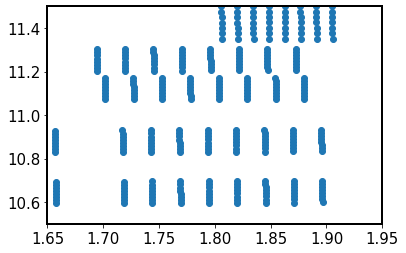

In [35]:
%matplotlib inline
plt.scatter(coords['ra'],coords['dec'])
plt.xlim(1.65,1.95)
plt.ylim(10.5,11.5)

Why are these not symmetrical? I'm really confused about how skySim makes the simulation... Try running it with really short exposure, and see the result ... 

Make an inst catalog

In [38]:
# it happens that this code is at the same level
# as the /home/scichris/notebooks/
# so it can be imported directly 
import run_ps1_1_catalogs as ps1_cat
import run_ps1_phosim as ps1_phosim

import imp
imp.reload(ps1_cat)

import pandas as pd
# for a grid of stars on corner sensors
#coords = Table.read('corner_sensors_grid.txt')

# for a grid of stars on the lsstCam 
df = coords.to_pandas()

position = "extra" # extra , intra 
exposure= 15
inst_file = f'lsstCam_star_grid_{exposure}-sec.inst'

ps1_cat.write_phosim_inst_file(df, ra=raInDeg, dec=declInDeg, phosim_file  = inst_file,
                          out_dir='/project/scichris/aos/AOS/DM-28360',mjd=mjd,
                          magcol='r', exposure=exposure, position=position )

Saved as  /project/scichris/aos/AOS/DM-28360/lsstCam_star_grid_15-sec.inst


    ssh scichris@lsst-login01.ncsa.illinois.edu 
    ssh lsst-devl03 
    source "/software/lsstsw/stack/loadLSST.bash"    # need that for python 
    setup lsst_distrib 

    setup phosim_utils -r /project/scichris/aos/phosim_utils/
    
    or
    
    ssh lsst-devl02
    screen -x pert  (already has the stack and phosim_utils setup) 
    

In [39]:
import os
import run_ps1_phosim as ps1_phosim
root_dir = '/project/scichris/aos/AOS/DM-28360'
cmd_file=  'noBkgndPert00_NCSA.cmd'# 'qckBkgndPert00_NCSA.cmd'# 'qckBkgnd.cmd' # quick background, small perturbations ... 
phosim_path="/project/scichris/aos/phosim_syseng4/phosim.py"

#inst_file = 'corner_single_star_focal.inst'
inst_file = 'stars_lsstCam_PS1_med_focal_9011021.inst'
inst_file_path = os.path.join(root_dir, inst_file)
cmd_file_path = os.path.join(root_dir, cmd_file)
instr = 'lsst'

sensorName = ["R04_SW0", "R04_SW1",
             "R44_SW0", "R44_SW1",
             "R00_SW0", "R00_SW1",
             "R40_SW0", "R40_SW1"
             ]

phosim_p = 24
phosim_s = ['']#sensorName
work_dir = os.path.join(root_dir, f'lsstCam_grid_{position}_{cmd_file[:-4]}_{exposure}-sec')
out_dir = os.path.join(work_dir, "raw")

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

log_file = os.path.join(work_dir, "starPhoSim.log")

command = f"python {phosim_path} {inst_file_path} -i {instr} -e 1 \
-c {cmd_file_path} -w {out_dir} -p {phosim_p}  -o {out_dir} "

# add sensor selection
if len(phosim_s[0]) > 0:
    sensor_names = ps1_phosim.sensor_list_to_string(phosim_s)
    command += f' -s "{sensor_names}"'

# end of the command
command += f"> {log_file} 2>&1"
phosim_command = command

print(f"\nRunning via subprocess: \n\n {command}\n")

#if subprocess.call(command, shell=True) != 0:
#    raise RuntimeError("Error running: %s" % command)


Running via subprocess: 

 python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/AOS/DM-28360/lsstCam_star_grid_15-sec.inst -i lsst -e 1 -c /project/scichris/aos/AOS/DM-28360/noBkgndPert00_NCSA.cmd -w /project/scichris/aos/AOS/DM-28360/lsstCam_grid_extra_noBkgndPert00_NCSA_15-sec/raw -p 24  -o /project/scichris/aos/AOS/DM-28360/lsstCam_grid_extra_noBkgndPert00_NCSA_15-sec/raw > /project/scichris/aos/AOS/DM-28360/lsstCam_grid_extra_noBkgndPert00_NCSA_15-sec/starPhoSim.log 2>&1



In [40]:
# Repackage:
#position="focal"
focuszDict = {"focal": 0, "intra": 1500, "extra": -1500}
focusz = focuszDict[position]

repackaged_dir = os.path.join(work_dir, "repackaged")
command = f"phosim_repackager.py {out_dir} \
--out_dir {repackaged_dir} --inst {instr} --focusz {focusz}"

print(f"\nRunning via subprocess: \n {command}\n")



Running via subprocess: 
 phosim_repackager.py /project/scichris/aos/AOS/DM-28360/lsstCam_grid_extra_noBkgndPert00_NCSA_15-sec/raw --out_dir /project/scichris/aos/AOS/DM-28360/lsstCam_grid_extra_noBkgndPert00_NCSA_15-sec/repackaged --inst lsst --focusz -1500



Ingest and ISR:

In [41]:
# go into that dir, copy the isr pipeline , run it 
print(f"cd {work_dir}")
print(f"cp ../corner_sensor_single/runIsr.sh .")
print(f"cp ../corner_sensor_single/testPipeline.yaml .")
print()

cd /project/scichris/aos/AOS/DM-28360/lsstCam_grid_extra_noBkgndPert00_NCSA_15-sec
cp ../corner_sensor_single/runIsr.sh .
cp ../corner_sensor_single/testPipeline.yaml .



In [ ]:
Find out the airmass and seeing.. 

In [18]:
fpath = '/project/scichris/aos/AOS/DM-28360/lsstCam/high/focal/9010021/repackaged/MC_H_20211231_010021_R00_SW0.fits'

In [19]:
hdul = fits.open(fpath)

import numpy as np
seeing = []
outer_scale=[]
heights=[]
for j in range(7):
    see = hdul[1].header[f'SEE{j}']
    oscale = hdul[1].header[f'OSCL{j}']
    height = hdul[1].header[f'HGT{j}']
    print(see)
    seeing.append(see)
    heights.append(height)
    outer_scale.append(oscale)
    

add_quad_seeing_sigma = np.sqrt(np.sum(np.square(seeing)))
fwhm_sigma = 2.355*add_quad_seeing_sigma
print(fwhm_sigma)#*zfactor)

0.070356
0.060413
0.046016
0.008804
0.043693
0.050081
0.210822
0.5752073903703584


# Show here the postISR image: 

In [2]:
from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astropy.io import fits
from astropy.visualization import ZScaleInterval

import numpy as np 
import os 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
def plot_raw_postISR(repo_dir,instrument,detector='R22_S11'):
    
    butler = dafButler.Butler(repo_dir, collections=[f'{instrument}/raw/all',
                                                     f'{instrument}/calib','run1',
                                                     f'{instrument}/calib/unbounded'],
                             )


    # this is just to get the exposure  number
    # so that we don't have  to guess...
    dataId0 = dict(instrument=instrument)
    dataset = next(iter(
                        butler.registry.queryDatasets(
                            datasetType='postISRCCD', 
                            collections=['run1'],
                            dataId=dataId0  )
                        )
                   )
    exp_num = dataset.dataId["exposure"]
    print(exp_num)
    zscale = ZScaleInterval()
     
    # initialize the figure 
    fig,ax = plt.subplots(1,2,figsize=(18,9))

    # get the raw exposure 
    exposure = butler.get('raw', detector=detector, instrument=instrument,
              exposure=exp_num,)

    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)
    ax[0].imshow(exposure.image.array, vmin=vmin,vmax=vmax,cmap='Greys',
                origin='lower')

    ax[0].set_title("raw")
    ax[0].set_xlabel('x [px]')
    ax[0].set_ylabel('y [px]')

    # get the postISR exposure 
    exposure = butler.get('postISRCCD', detector=detector, instrument=instrument,
              exposure=exp_num,collections=['run1'])

    data = exposure.image.array
    vmin, vmax = zscale.get_limits(data)
    ax[1].imshow(exposure.image.array, vmin=vmin,vmax=vmax,cmap='Greys',
                origin='lower')

    ax[1].set_title("postISR")
    ax[1].set_xlabel('x [px]')
    ax[1].set_ylabel('y [px]')
    fig.suptitle(f"{instrument} {exposure.getDetector().getName()}",
                fontsize=18)


# med field 

4021123111021


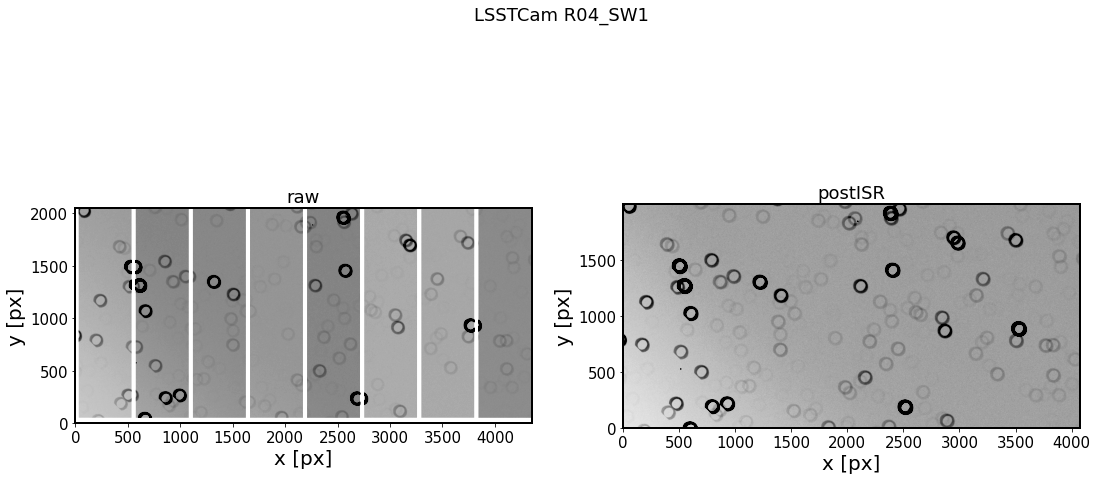

In [2]:
instrument='LSSTCam'
repo_dir = '/project/scichris/aos/AOS/DM-28360/lsstCam/med/focal/9011021/DATA/'
plot_raw_postISR(repo_dir,instrument, detector='R04_SW1') 

4021123102231


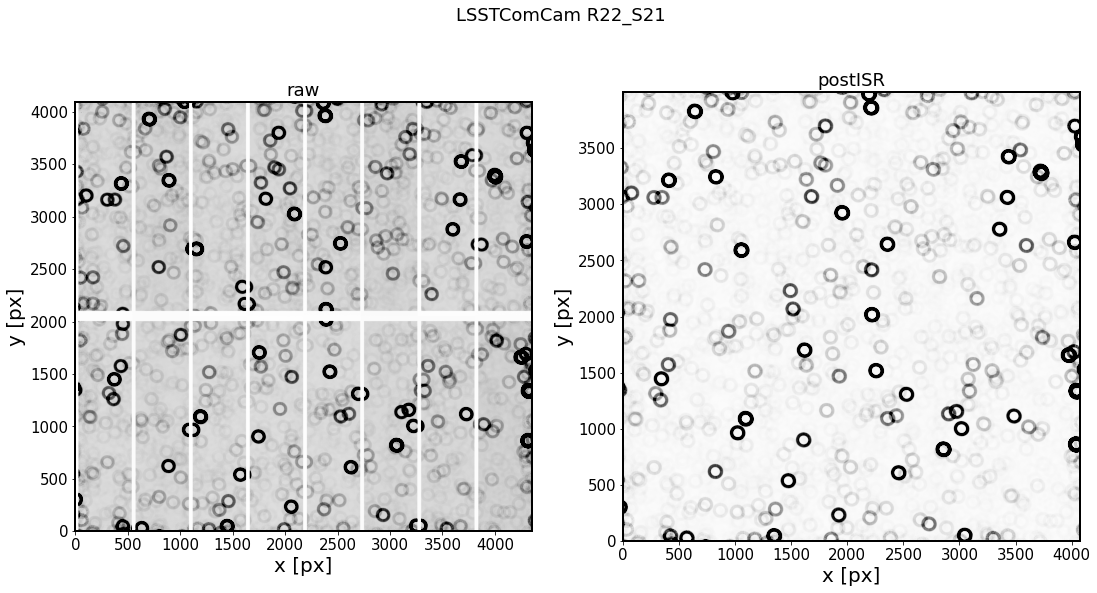

In [3]:
instrument='LSSTComCam'
repo_dir = '/project/scichris/aos/AOS/DM-28360/comCam/low/intra/9002231/DATA/'
plot_raw_postISR(repo_dir,instrument, detector='R22_S21') 


# compare to WCS 

In [2]:
%matplotlib inline

import pandas as pd

from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astropy.io import fits
from astropy.visualization import ZScaleInterval

import numpy as np 
import os 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
repo_dir = '/project/scichris/aos/AOS/DM-28360/lsstCam/med/focal/9011021/DATA/'
instrument = 'LSSTCam'
detector = 'R04_SW0'
print(f'Using {repo_dir}')
butler = dafButler.Butler(repo_dir, collections=[f'{instrument}/raw/all',
                                                 f'{instrument}/calib','run1',
                                                 f'{instrument}/calib/unbounded']
                         )
# this is just to get the exposure  number
# so that we don't have  to guess...
dataId0 = dict(instrument=instrument)
dataset = next(iter(
                    butler.registry.queryDatasets(
                        datasetType='postISRCCD', 
                        collections=['run1'],
                        dataId=dataId0  )
                    )
               )
exp_num = dataset.dataId["exposure"]

    
exposure = butler.get('postISRCCD', detector=detector, instrument=instrument,
          exposure=exp_num,collections=['run1'])
# read in the input instance catalog 
cat = np.genfromtxt('/project/scichris/aos/AOS/DM-28360/stars_lsstCam_PS1_med_focal_9011021.inst',
                        skip_header=16)

cat_df = pd.DataFrame(cat[:, 1:5], columns=['id', 'ra', 'dec', 'g'])


# get the wcs 
wcs = exposure.getWcs()

# calculate the position given the x,y 
x,y = wcs.skyToPixelArray(cat_df['ra'], cat_df['dec'],degrees=True)





Using /project/scichris/aos/AOS/DM-28360/lsstCam/med/focal/9011021/DATA/


In [3]:
print(exposure.getInfo())

Text(0, 0.5, 'y [px]')

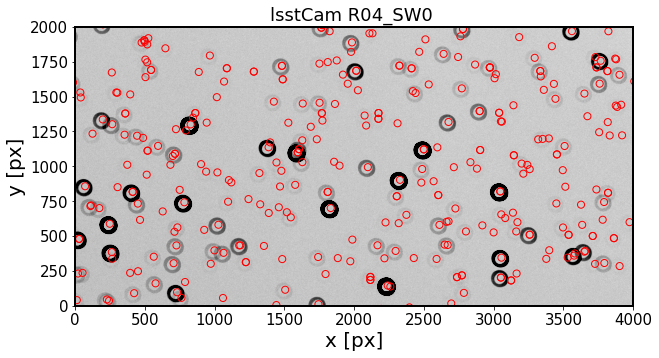

In [7]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

# plot the WCS-inferred stellar position on top of the data 
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)

fig = plt.figure(figsize=(10,10))
plt.imshow(np.flipud(np.fliplr(data)), vmin=vmin,vmax=vmax,cmap='Greys')
plt.scatter(x, y,  facecolors='none', edgecolors='r', marker='o',s=50, )
plt.xlim(0, 4000)
plt.ylim(0, 2000)
plt.title(f"lsstCam {exposure.getDetector().getName()} ")
plt.xlabel('x [px]')
plt.ylabel('y [px]')

In [ ]:
That's interesting! Need to flip left-right, up-down to match the WCS information...

It looks incorrect. Try changing the rotang:

In [25]:
from lsst.obs.base import (bboxFromIraf, MakeRawVisitInfoViaObsInfo, 
createInitialSkyWcs, createInitialSkyWcsFromBoresight)
import lsst.geom

from lsst.daf import butler as dafButler
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.display as afwDisplay

########### CHANGE ROTANG 
###########

# obtain the postISR metadata from the exposure 
postIsr_md = exposure.getMetadata()
postIsr_visit_info = postIsr_md.keys()
postIsr_md['RA_DEG'], postIsr_md['DEC_DEG'], postIsr_md['ROTANG']


# get the WCS using the input ROTANG 
pointing_loc = lsst.geom.SpherePoint(postIsr_md['RA_DEG'], postIsr_md['DEC_DEG'], 
                                     lsst.geom.degrees)
new_wcs = createInitialSkyWcsFromBoresight(pointing_loc, 
                                           (90+postIsr_md['ROTANG'])*lsst.geom.degrees,
                                           exposure.getDetector(),
                                           flipX=False)


# calculate the position given the x,y 
new_x = []
new_y  = []

for i in range(len(cat_df)):
    x_pix, y_pix = new_wcs.skyToPixel(
        lsst.geom.SpherePoint(
            cat_df.iloc[i]['ra'], cat_df.iloc[i]['dec'], lsst.geom.degrees
        )
    )
    new_x.append(x_pix)
    new_y.append(y_pix)
    
    
    

Text(0, 0.5, 'y [px]')

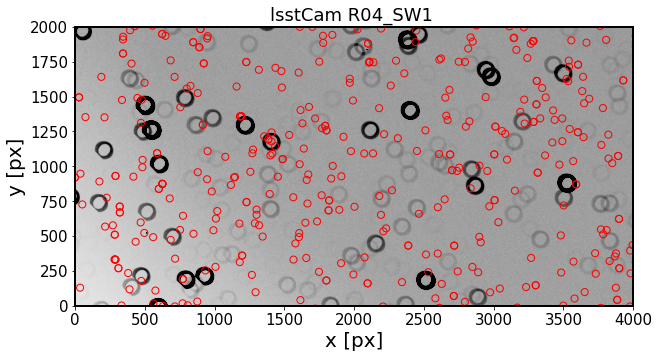

In [24]:
    
# plot the WCS-inferred stellar position on top of the data 
data = exposure.image.array
vmin, vmax = zscale.get_limits(data)

fig = plt.figure(figsize=(10,10))
plt.imshow(data, vmin=vmin,vmax=vmax,cmap='Greys')
plt.scatter(new_x,new_y,  facecolors='none', edgecolors='r', marker='o',s=50, )
plt.xlim(0, 4000)
plt.ylim(0, 2000)
plt.title(f"lsstCam {exposure.getDetector().getName()} ")
plt.xlabel('x [px]')
plt.ylabel('y [px]')

# single donuts 

4016091606002


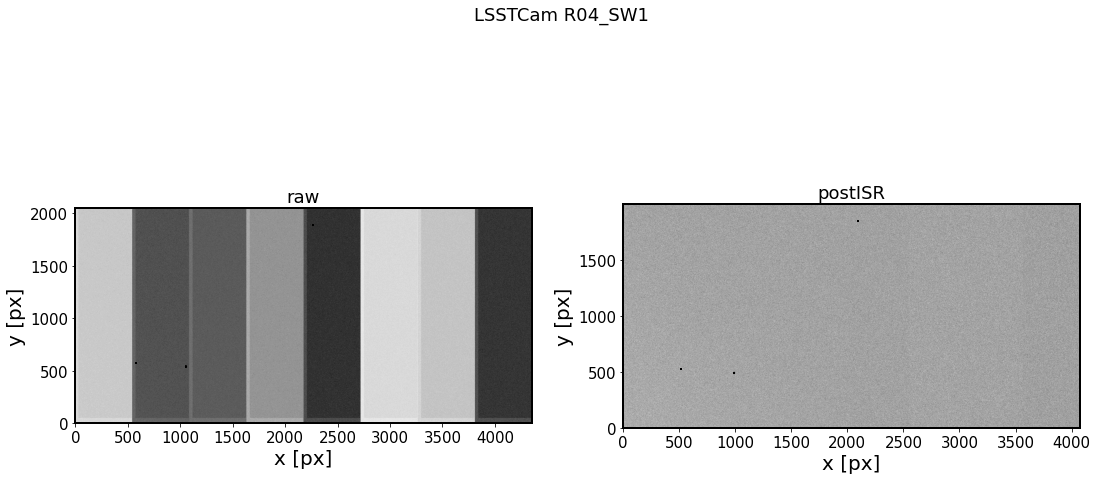

In [82]:
# Here the donuts are too large, because 
# the main rafts are defocal, and the corner sensors are too much out of focus here ...
instrument='LSSTCam'
# it had move 10 -1500.0000, so it would have been extra-focal
# it moved SW0, which is at +1500, more out of focus 
# it moved SW1, which is at -1500, into focus 
repo_dir = '/project/scichris/aos/AOS/DM-28360/corner_sensor_single/DATA/'
plot_raw_postISR(repo_dir,instrument, detector='R04_SW1') 

4016091606002


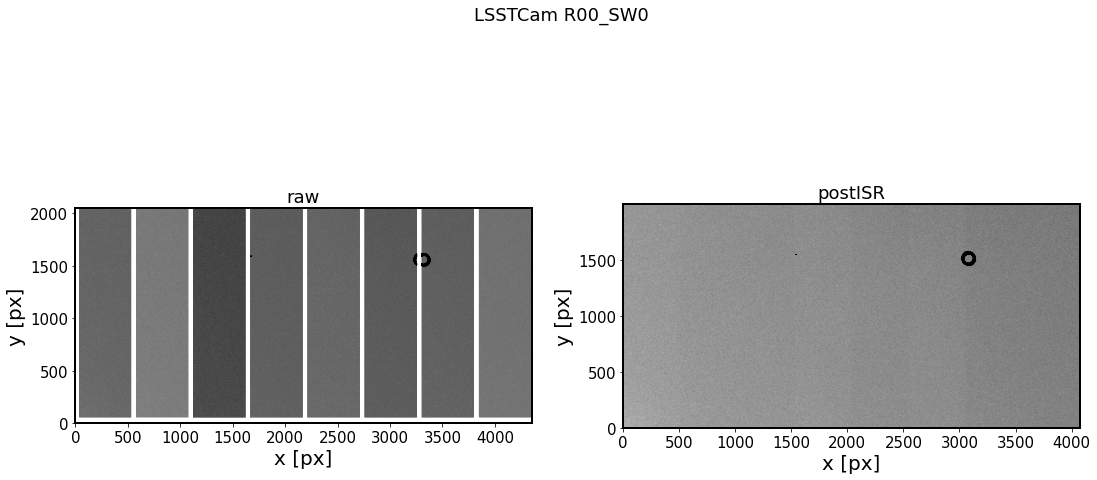

In [34]:
%matplotlib inline
# This is in focus, so the donut size is correct, but
# because I used quick background, on the SW1 sensors
# there is that gradient that I do not understand .... 
# It is not visible on the SW0 chips (!)
instrument='LSSTCam'
repo_dir = '/project/scichris/aos/AOS/DM-28360/corner_sensor_single_focal/DATA/'
plot_raw_postISR(repo_dir,instrument, detector='R00_SW0') 

4016091606002


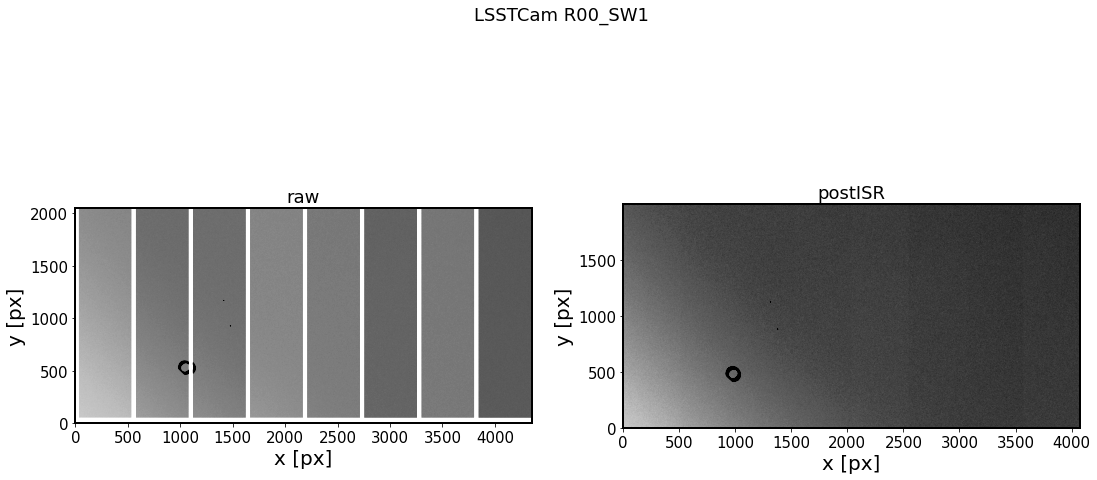

In [35]:
plot_raw_postISR(repo_dir,instrument, detector='R00_SW1') 

4016091606002


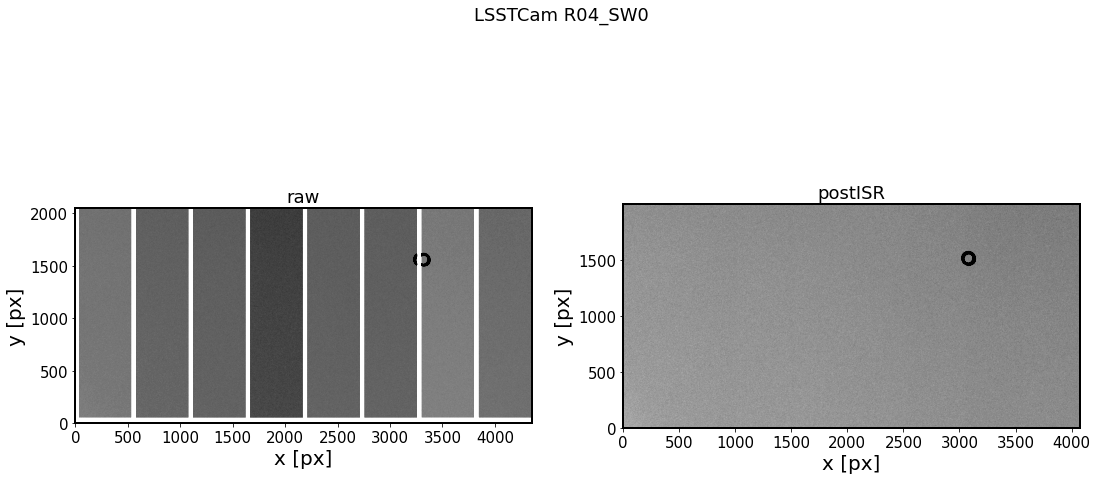

In [36]:
plot_raw_postISR(repo_dir,instrument, detector='R04_SW0') 

4016091606002


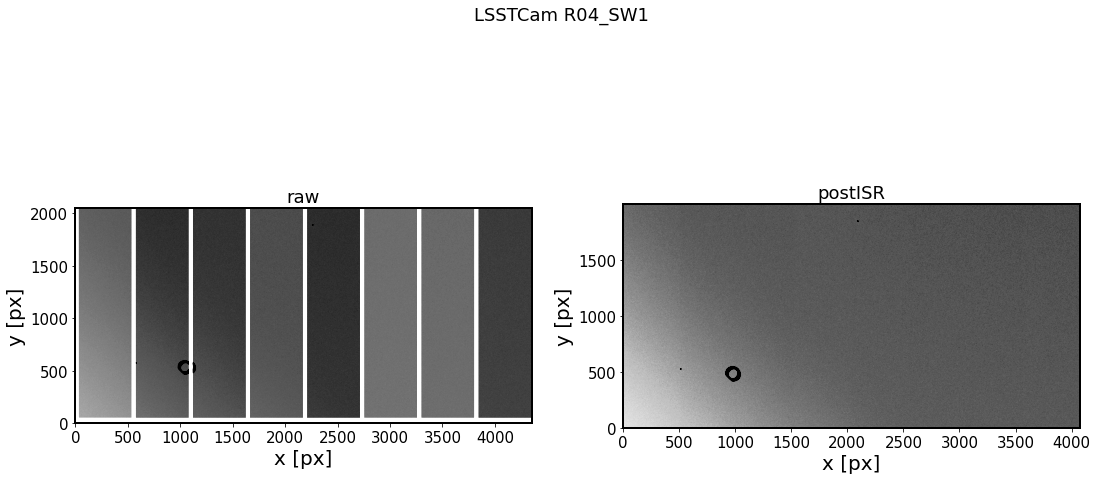

In [37]:
plot_raw_postISR(repo_dir,instrument, detector='R04_SW1') 

4016091606002


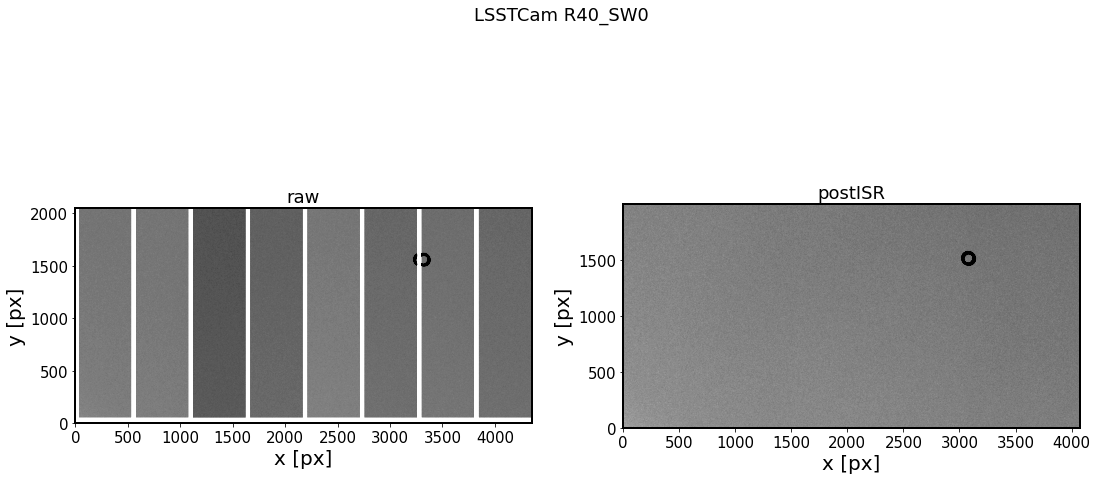

In [38]:
plot_raw_postISR(repo_dir,instrument, detector='R40_SW0') 

4016091606002


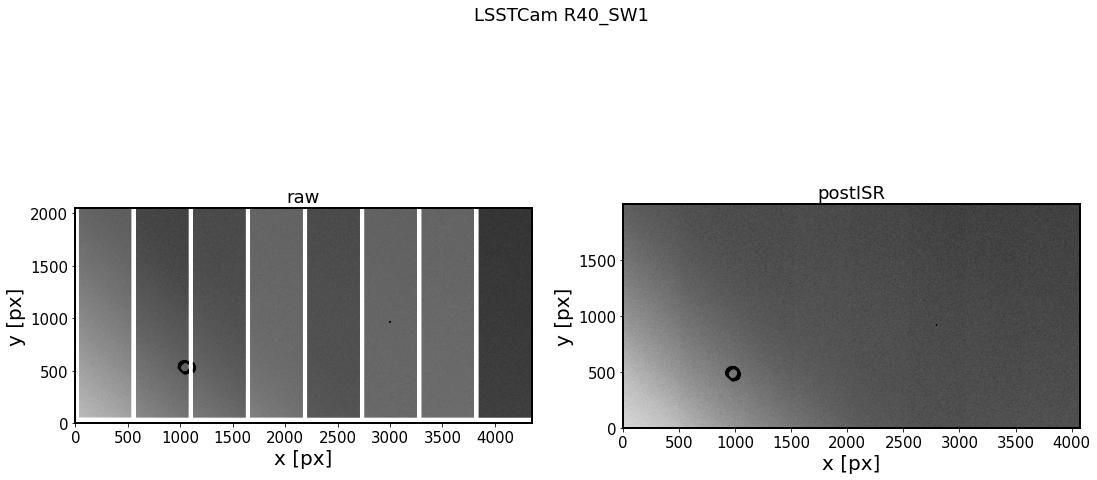

In [39]:
plot_raw_postISR(repo_dir,instrument, detector='R40_SW1') 

4016091606002


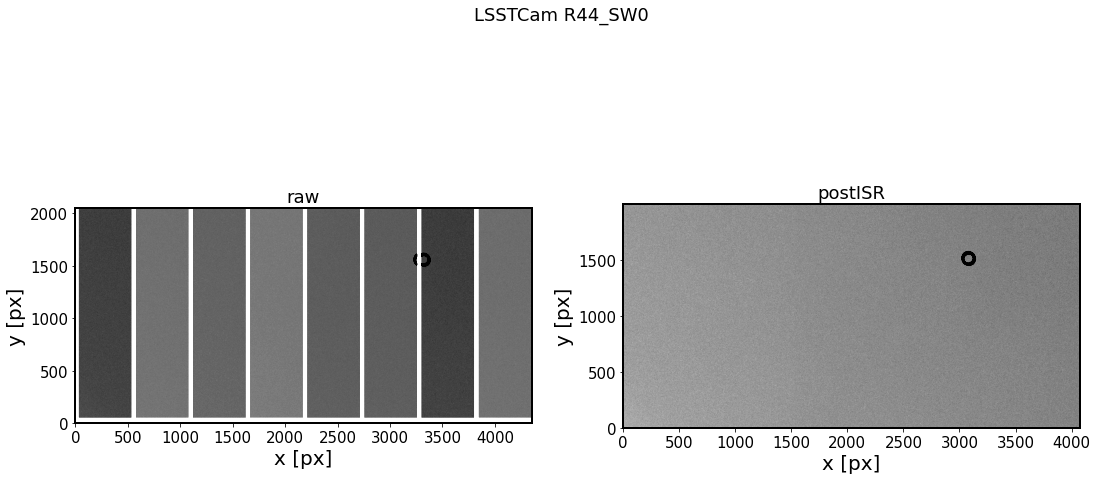

In [40]:
plot_raw_postISR(repo_dir,instrument, detector='R44_SW0') 

4016091606002


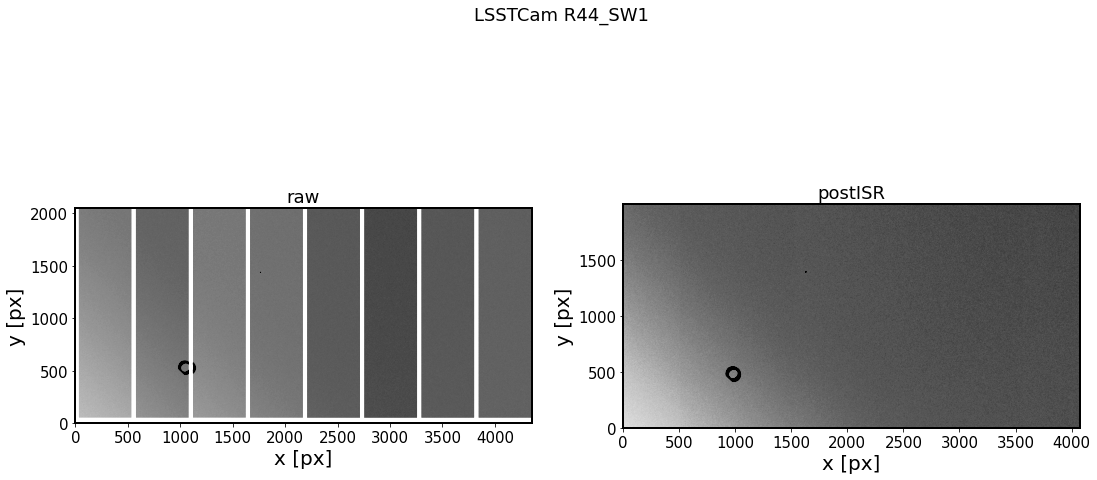

In [41]:
plot_raw_postISR(repo_dir,instrument, detector='R44_SW1') 

Is it there also in short 1 sec exposure?  

4016091606002


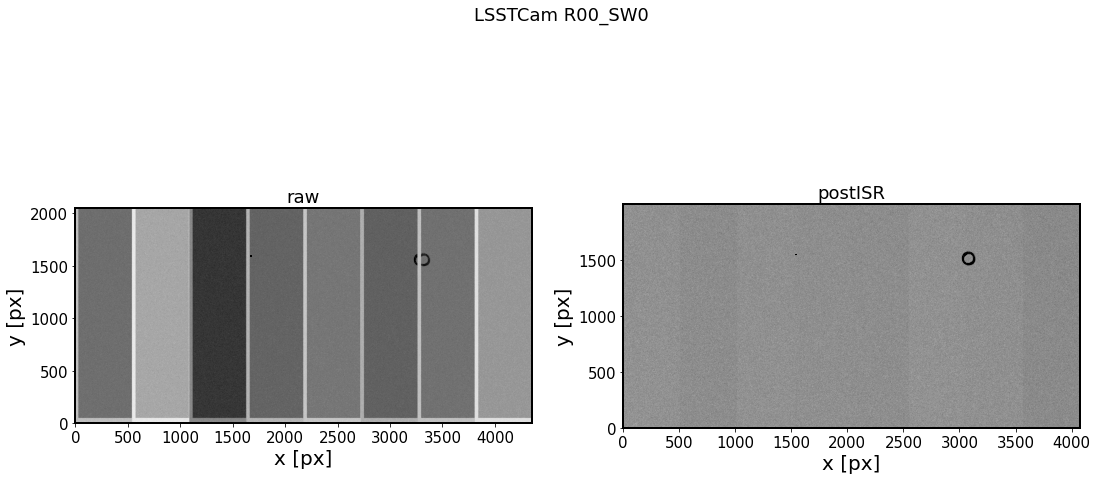

In [42]:
%matplotlib inline
# Here I have in-focus (correct donut size), but still using 
# quick  background, because I wondered whether the background
# gradient in the postISR image is still visible with shorter exposure,
# and  indeed, it is ... 
instrument='LSSTCam'
repo_dir = '/project/scichris/aos/AOS/DM-28360/corner_sensor_single_focal_1sec/DATA/'
plot_raw_postISR(repo_dir,instrument, detector='R00_SW0') 

4016091606002


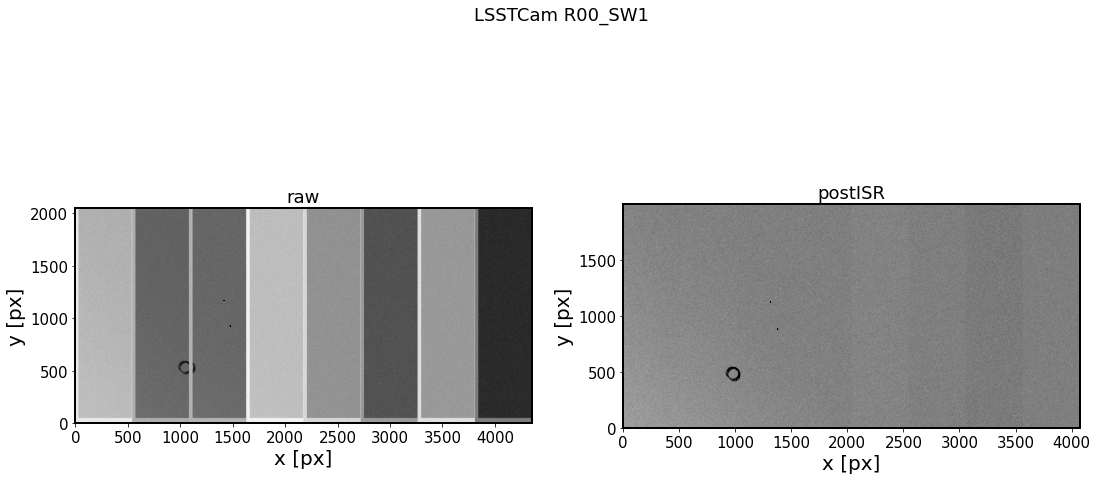

In [43]:
%matplotlib inline

instrument='LSSTCam'
repo_dir = '/project/scichris/aos/AOS/DM-28360/corner_sensor_single_focal_1sec/DATA/'
plot_raw_postISR(repo_dir,instrument, detector='R00_SW1') 

Still there, but not as pronounced... Try to see if it's there with quick background, 15 sec exp, but no perturbations at all:

4016091606002


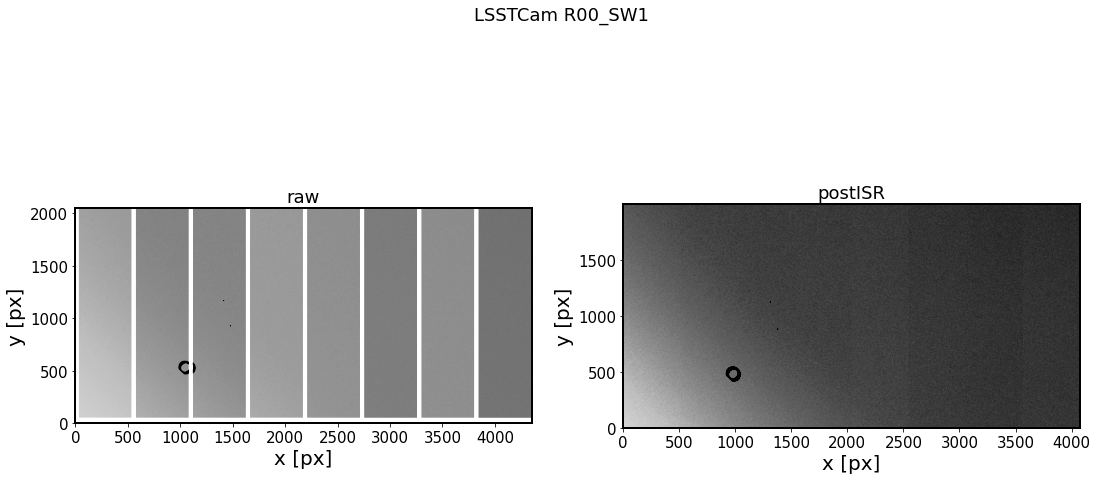

In [76]:
%matplotlib inline
# So I try to see if using quick background, 15 sec exposure, but absolutely no perturbations helps,
# but I see that it doesnt - therefore it's not due to the perturbations, but rather due to the 
# usage of quick background ... 
instrument='LSSTCam'
repo_dir = '/project/scichris/aos/AOS/DM-28360/corner_sensor_single_focal_noPert/DATA/'
plot_raw_postISR(repo_dir,instrument, detector='R00_SW1') 

4016091606002


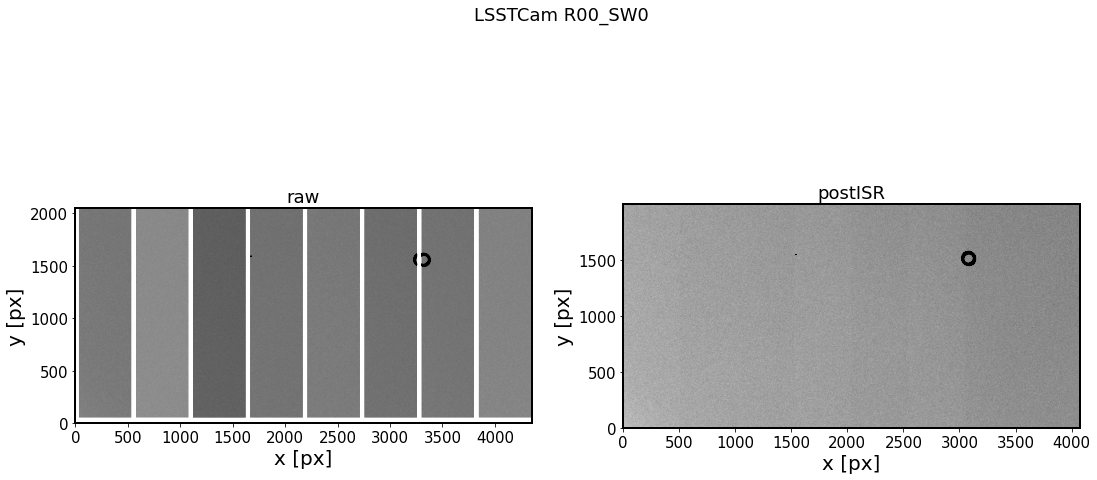

In [45]:
plot_raw_postISR(repo_dir,instrument, detector='R00_SW0') 

So it's only there for the SW1 but not SW0, even with no perturbations at all! Try no background, 15 sec exposure:

4016091606002


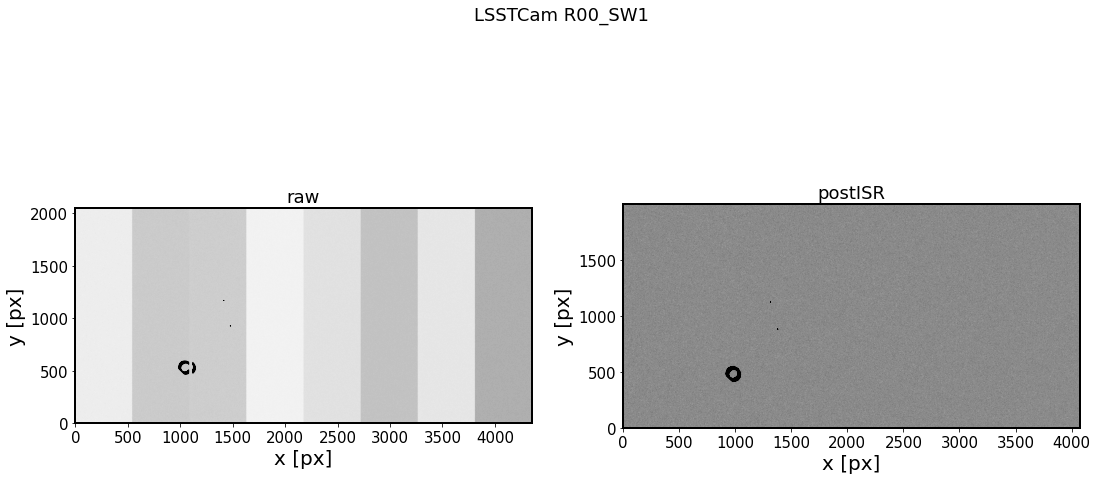

In [4]:
%matplotlib inline
# Here I run no perturbations, but also no background - the simplest case,
# with 15 sec exposure 
instrument='LSSTCam'
repo_dir = '/project/scichris/aos/AOS/DM-28360/corner_sensor_single_focal_noPert_noBkgnd/DATA/'
plot_raw_postISR(repo_dir,instrument, detector='R00_SW1') 

4021123110021


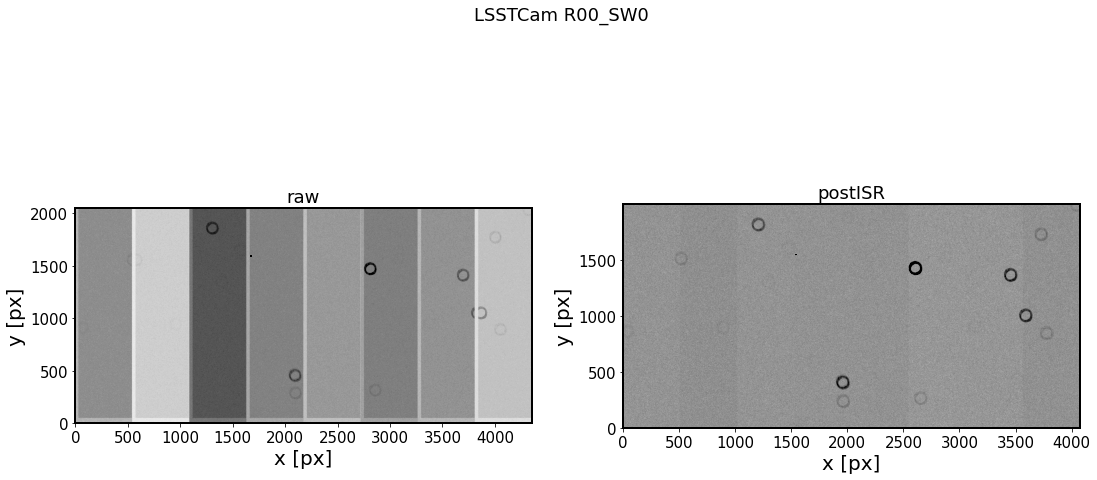

In [77]:
# This is the postISR which was using quick background, small perturbations
# 15 sec exposure, with PS1 high-latitude field. 
# I can't see the dradient probably because there are 
# other stars that are bright,
# but I do see that the ISR has not been done 
# perfectly; there are some non-uniformities ... 
instrument='LSSTCam'
repo_dir = '/project/scichris/aos/AOS/DM-28360/lsstCam/high/focal/9010021/DATA/'
plot_raw_postISR(repo_dir,instrument, detector='R00_SW0') 

In [33]:
hdul = fits.open('/project/scichris/aos/AOS/DM-28360/lsstCam/high/focal/9010021/repackaged/MC_H_20211231_010021_R00_SW0.fits')
#for i in range(1,len(hdul)):
i=1
print(hdul[i].header['CHIPID'], hdul[i].header['AMPID'])
seeing=[]
for j in range(7):
    see = hdul[i].header[f'SEE{j}']
    seeing.append(see)
    print(see, 'arcsec', hdul[i].header[f'HGT{j}'], ' [km]')
np.sum(seeing)    

R00_SW0 C10
0.070356 arcsec 16.0  [km]
0.060413 arcsec 8.0  [km]
0.046016 arcsec 4.0  [km]
0.008804 arcsec 2.0  [km]
0.043693 arcsec 1.0  [km]
0.050081 arcsec 0.5  [km]
0.210822 arcsec 0.02  [km]


0.49018500000000004

In [35]:
0.69/np.power(1/np.cos(np.deg2rad(36.755732)), 0.6)

0.6040761477676879

In [34]:
hdul[1].header['ZENITH']

36.755732

Ok, so for now just simulate without background:

4016091606002


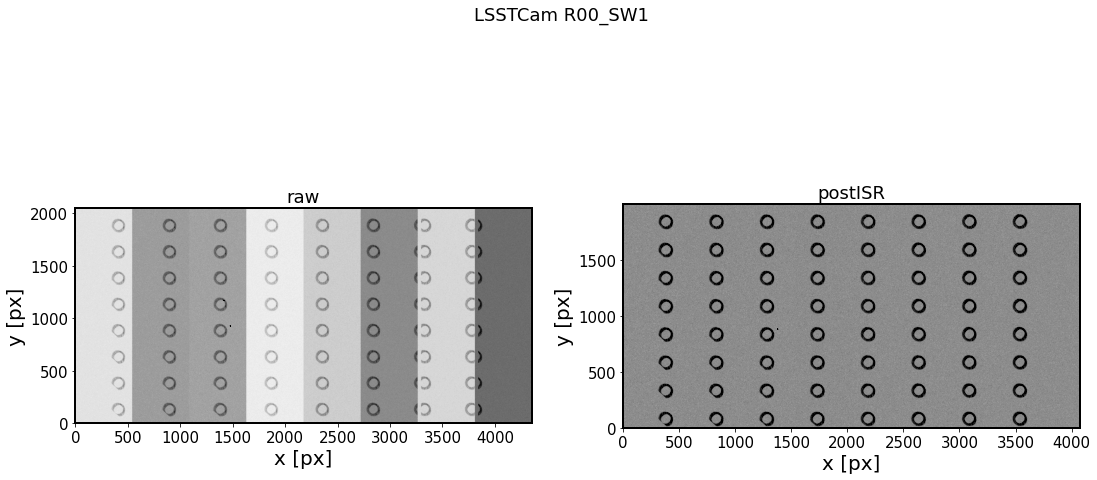

In [61]:
# inspect the stellar grid - the 1 sec no Bkgnd test
instrument='LSSTCam'
repo_dir = '/project/scichris/aos/AOS/DM-28360/corner_sensor_grid_focal_noBkgnd_1-sec/DATA/'
plot_raw_postISR(repo_dir,instrument, detector='R00_SW1') 


4016091606002


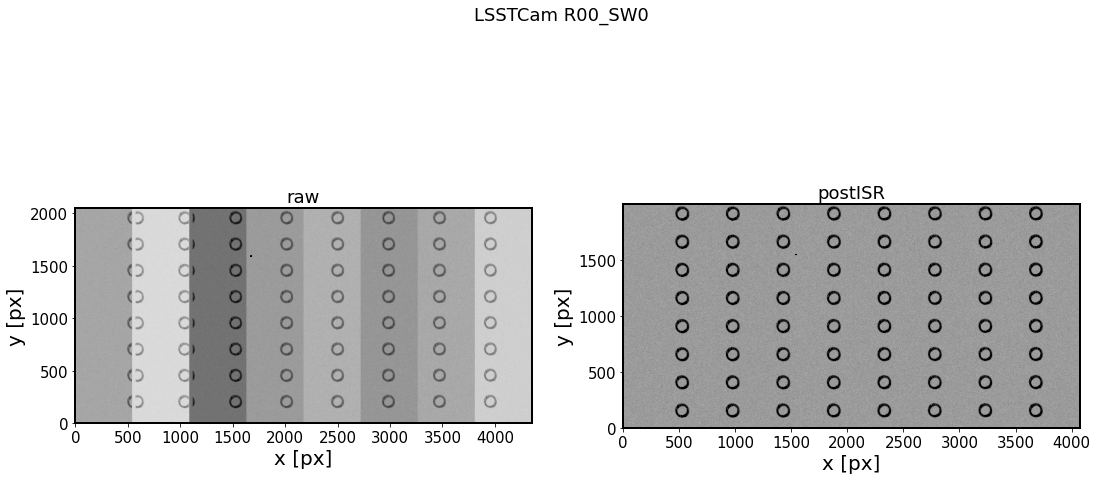

In [62]:
plot_raw_postISR(repo_dir,instrument, detector='R00_SW0')

4016091606002


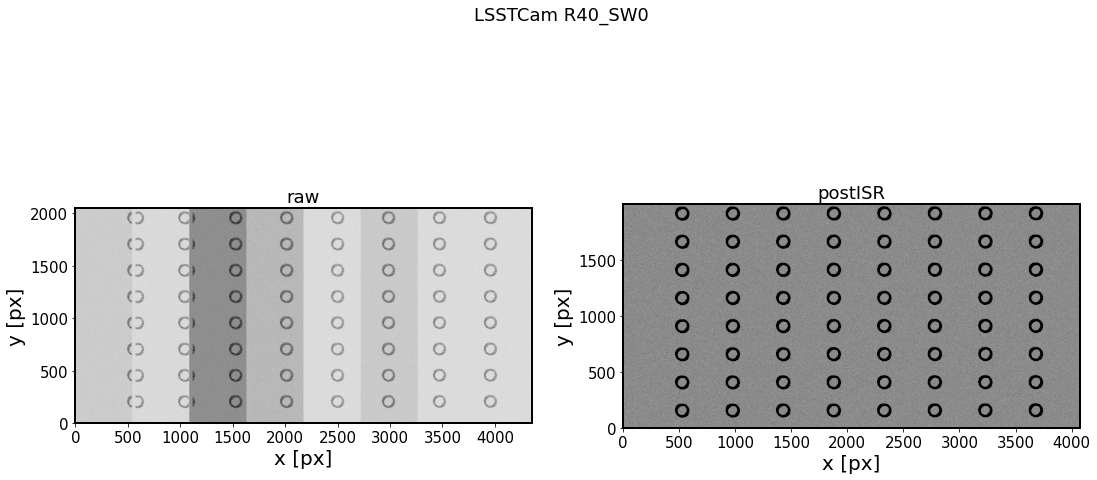

In [63]:
plot_raw_postISR(repo_dir,instrument, detector='R40_SW0')

4016091606002


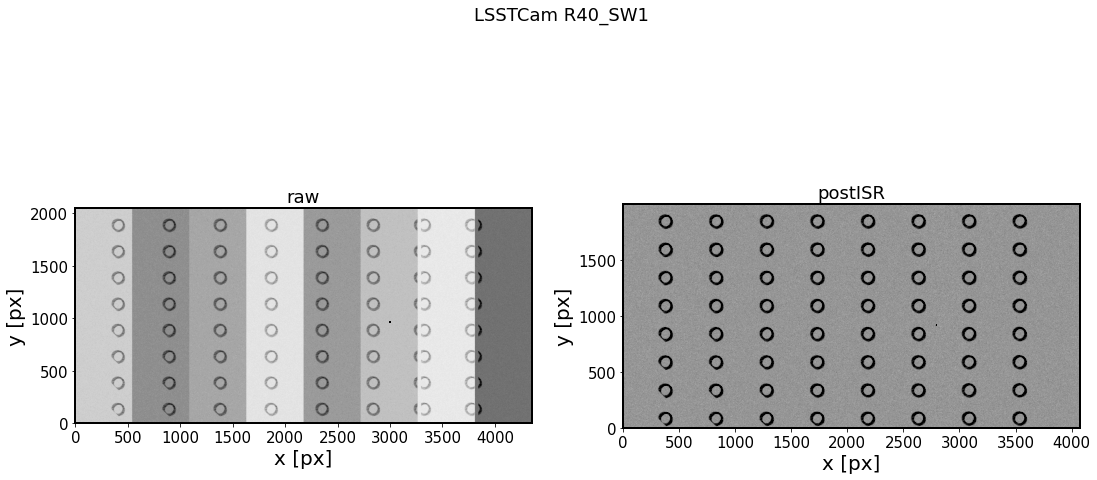

In [64]:
plot_raw_postISR(repo_dir,instrument, detector='R40_SW1')

4016091606002


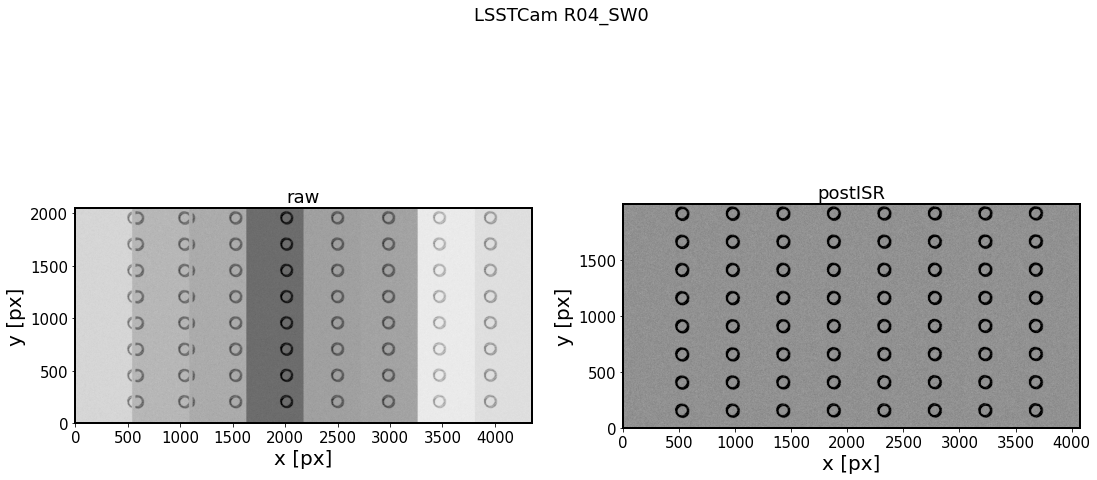

In [65]:
plot_raw_postISR(repo_dir,instrument, detector='R04_SW0')

4016091606002


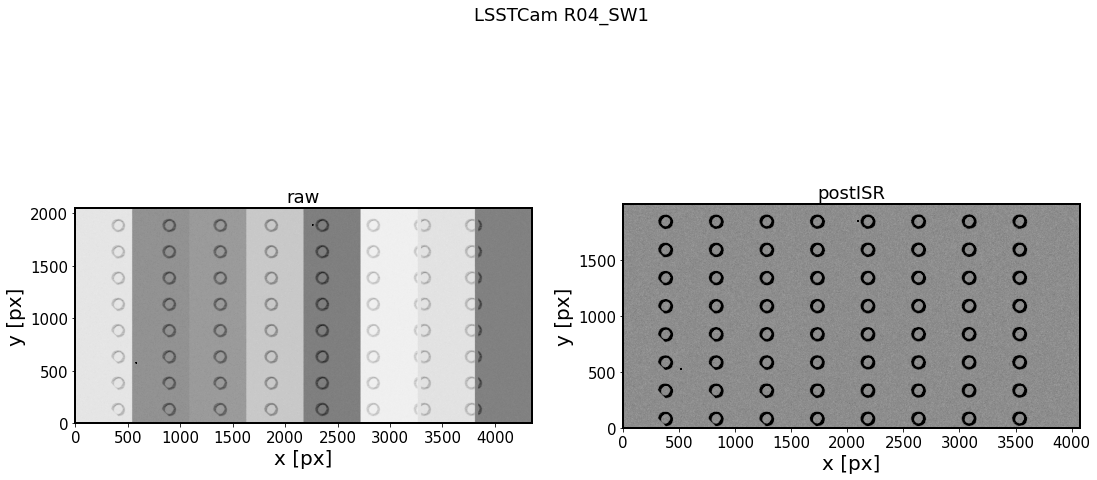

In [66]:
plot_raw_postISR(repo_dir,instrument, detector='R04_SW1')

4016091606002


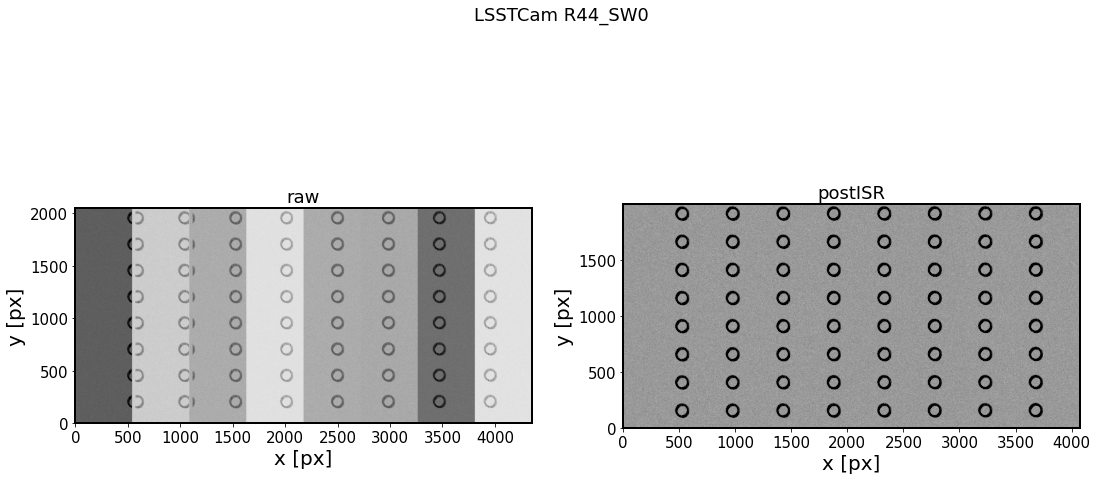

In [67]:
plot_raw_postISR(repo_dir,instrument, detector='R44_SW0')

4016091606002


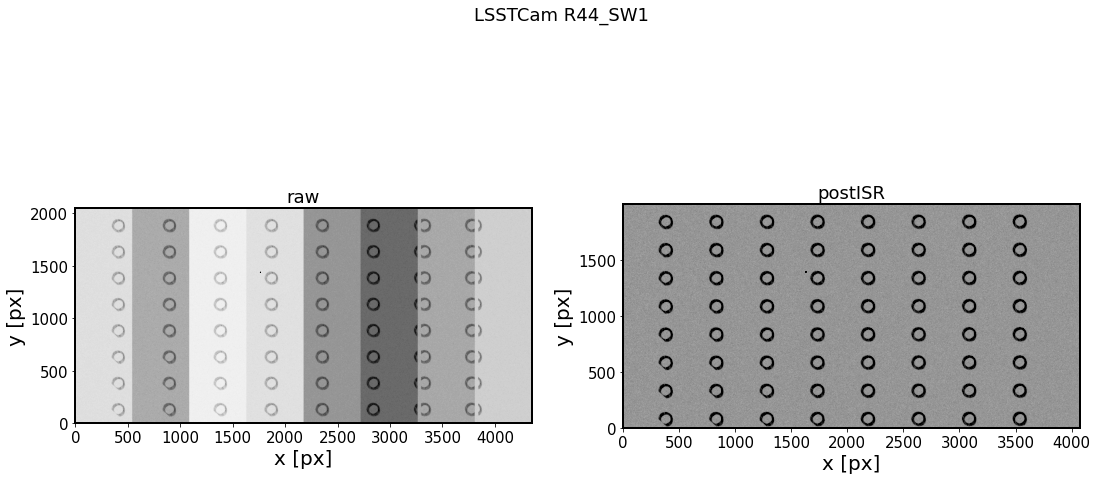

In [68]:
plot_raw_postISR(repo_dir,instrument, detector='R44_SW1')

Looks good - increase the exposure time to 15 sec, small perturbations, still no backround 

4016091606002


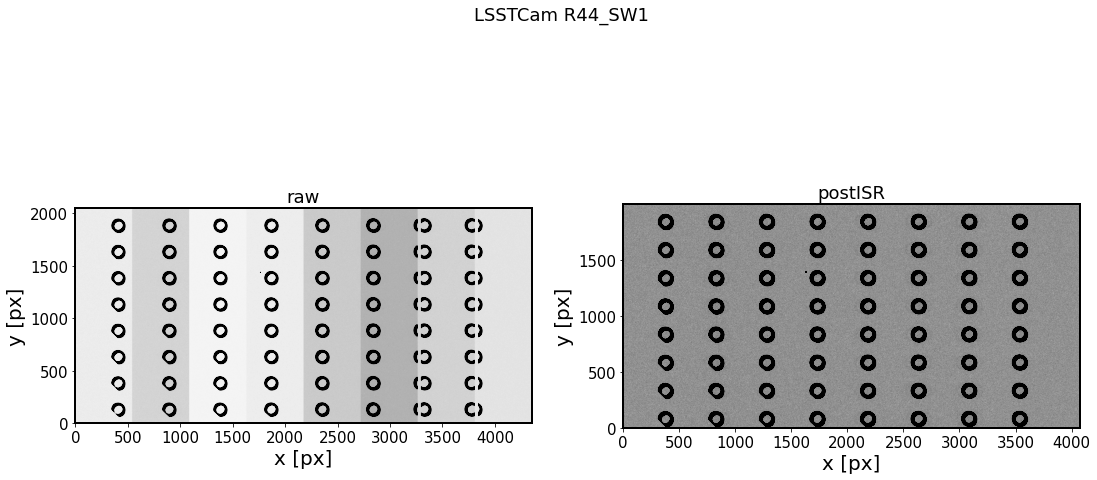

In [75]:
# plot the 15 sec no background, small pert 
# /project/scichris/aos/AOS/DM-28360/corner_single_star_grid_15-sec.inst 

instrument='LSSTCam'
repo_dir = '/project/scichris/aos/AOS/DM-28360/corner_sensor_grid_focal_noBkgndPert00_NCSA_15-sec/DATA/'
plot_raw_postISR(repo_dir,instrument, detector='R44_SW1')

4021123101201


LookupError: Dataset postISRCCD with data ID {instrument: 'LSSTComCam', detector: 3, exposure: 4021123101201} could not be found in collections ['run1'].

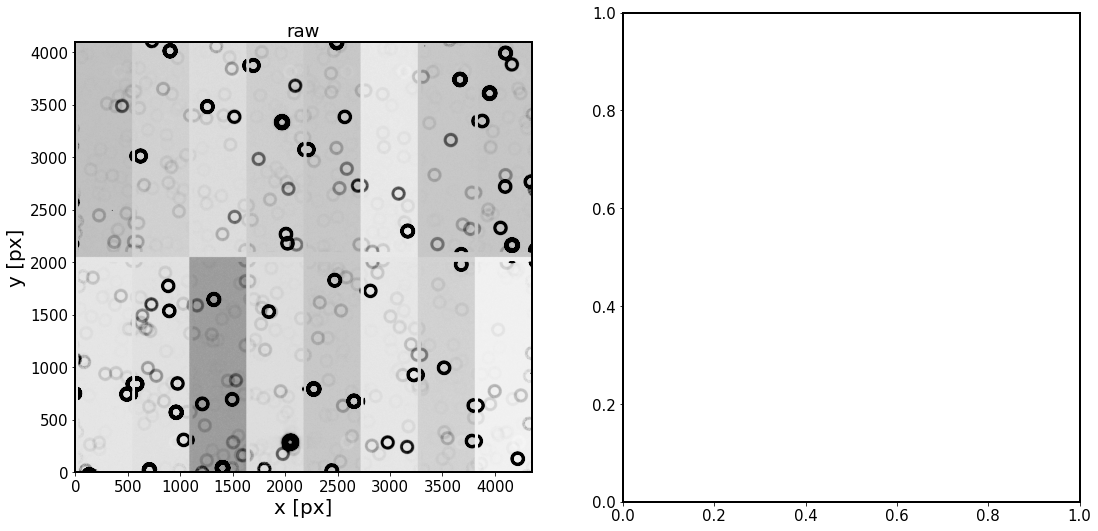

In [73]:
instrument='LSSTComCam'
repo_dir = '/project/scichris/aos/AOS/DM-28360/comCam/med/intra/9001201/DATA'
plot_raw_postISR(repo_dir,instrument, detector='R22_S10')

In [2]:
# this was made with opsim_rawseeing 0.69 
from astropy.io import fits
hdul = fits.open('/project/scichris/aos/AOS/DM-28360/\
corner_sensor_grid_focal_noBkgndPert00_NCSA_15-sec/\
repackaged/MC_H_20160916_006002_R00_SW0.fits')

In [3]:
hdul[1].header['ZENITH']

36.755732

In [1]:
#hdul[1].header

Made with `data/sky/sed_flat.txt` , rather than `sed_500.txt`.... 

In [5]:
import numpy as np
sed = np.loadtxt('/project/scichris/aos/phosim_syseng4/data/sky/sed_flat.txt')

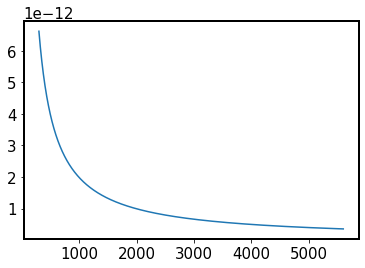

In [12]:
%matplotlib inline
plt.plot(sed[:,0], sed[:,1])

In [10]:
import numpy as np
seeing = []
outer_scale=[]
heights=[]
for j in range(7):
    see = hdul[1].header[f'SEE{j}']
    oscale = hdul[1].header[f'OSCL{j}']
    height = hdul[1].header[f'HGT{j}']
    print(see)
    seeing.append(see)
    heights.append(height)
    outer_scale.append(oscale)
    

add_quad_seeing_sigma = np.sqrt(np.sum(np.square(seeing)))
fwhm_sigma = 2.355*add_quad_seeing_sigma
print(fwhm_sigma)#*zfactor)

0.076035
0.05734
0.119929
0.017435
0.055002
0.11516
0.214045
0.6900529712002825


In [11]:
add_quad_seeing_sigma

0.29301612365192464

In [20]:
print(heights)

[16.0, 8.0, 4.0, 2.0, 1.0, 0.5, 0.02]


In [17]:
print(outer_scale)

[60.925117, 29.794481, 41.970444, 22.050776, 38.089558, 117.288635, 10.0]


In [60]:
np.square(seeing)

array([0.00578132, 0.00328788, 0.01438297, 0.00030398, 0.00302522,
       0.01326183, 0.04581526])

In [62]:
0.119929**2.0

0.014382965040999998

In [63]:
zfactor


NameError: name 'zfactor' is not defined

In [64]:
zenith = hdul[1].header['ZENITH']

In [65]:
zfactor = np.power(1/np.cos(np.deg2rad(zenith)),0.6)
print(zfactor)
seeing_z = np.array(seeing)*zfactor
print(np.sum(seeing_z))

1.1422401009373344
0.7481055851485036


In [31]:
seeings = [0.076035, 0.057340, 0.119929, 0.017435, 0.055002, 0.115160, 0.214045 ]
np.sum(seeings)

0.654946

In [29]:
#hdul = fits.open('/project/scichris/aos/AOS/DM-28360/lsstCam/high/focal/9010021/repackaged/MC_H_20211231_010021_R00_SW0.fits')
for i in range(1,len(hdul)):
    print('\n',hdul[i].header['CHIPID'], hdul[i].header['AMPID'])
    for j in range(7):
        print(hdul[i].header[f'SEE{j}'], 'arcsec', hdul[i].header[f'HGT{j}'], ' [km]')


 R00_SW0 C10
0.076035 arcsec 16.0  [km]
0.05734 arcsec 8.0  [km]
0.119929 arcsec 4.0  [km]
0.017435 arcsec 2.0  [km]
0.055002 arcsec 1.0  [km]
0.11516 arcsec 0.5  [km]
0.214045 arcsec 0.02  [km]

 R00_SW0 C11
0.076035 arcsec 16.0  [km]
0.05734 arcsec 8.0  [km]
0.119929 arcsec 4.0  [km]
0.017435 arcsec 2.0  [km]
0.055002 arcsec 1.0  [km]
0.11516 arcsec 0.5  [km]
0.214045 arcsec 0.02  [km]

 R00_SW0 C12
0.076035 arcsec 16.0  [km]
0.05734 arcsec 8.0  [km]
0.119929 arcsec 4.0  [km]
0.017435 arcsec 2.0  [km]
0.055002 arcsec 1.0  [km]
0.11516 arcsec 0.5  [km]
0.214045 arcsec 0.02  [km]

 R00_SW0 C13
0.076035 arcsec 16.0  [km]
0.05734 arcsec 8.0  [km]
0.119929 arcsec 4.0  [km]
0.017435 arcsec 2.0  [km]
0.055002 arcsec 1.0  [km]
0.11516 arcsec 0.5  [km]
0.214045 arcsec 0.02  [km]

 R00_SW0 C14
0.076035 arcsec 16.0  [km]
0.05734 arcsec 8.0  [km]
0.119929 arcsec 4.0  [km]
0.017435 arcsec 2.0  [km]
0.055002 arcsec 1.0  [km]
0.11516 arcsec 0.5  [km]
0.214045 arcsec 0.02  [km]

 R00_SW0 C15
0.0760